In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import chi2_contingency
from IPython.display import Audio

In [13]:
# Paths to the correct and incorrect pronunciation folders
correct_folder = 'dataset\\Tajweed\\14_sawad'
incorrect_folder = 'dataset\\Non Tajweed'

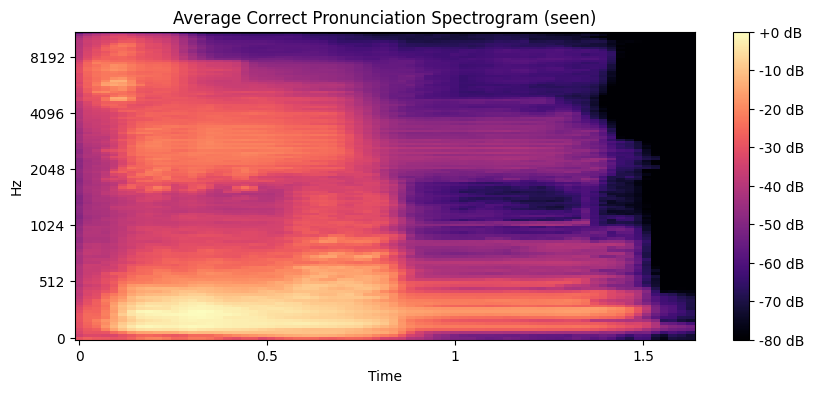

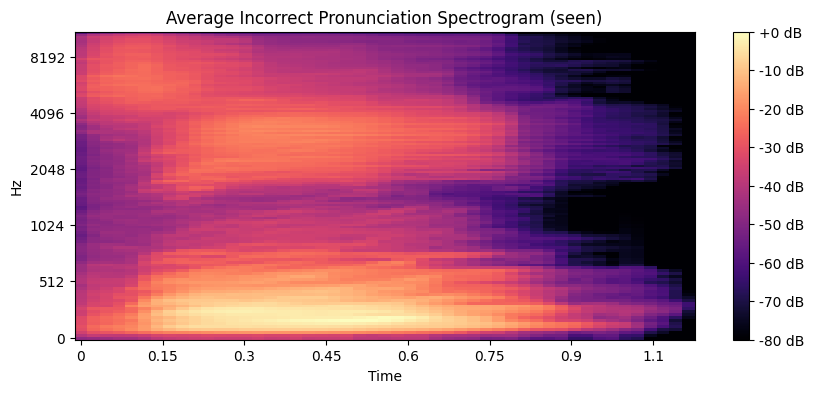

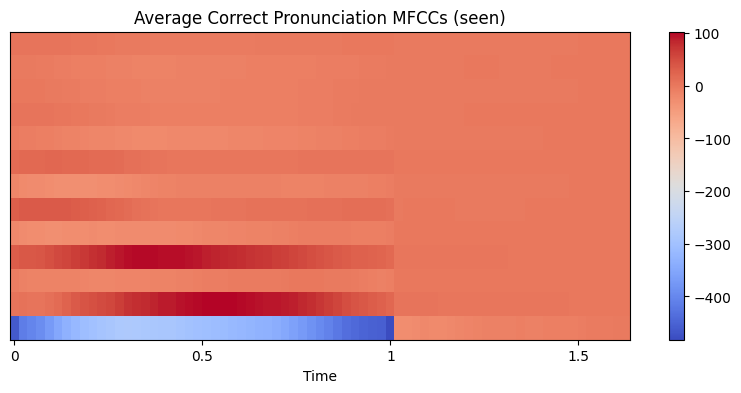

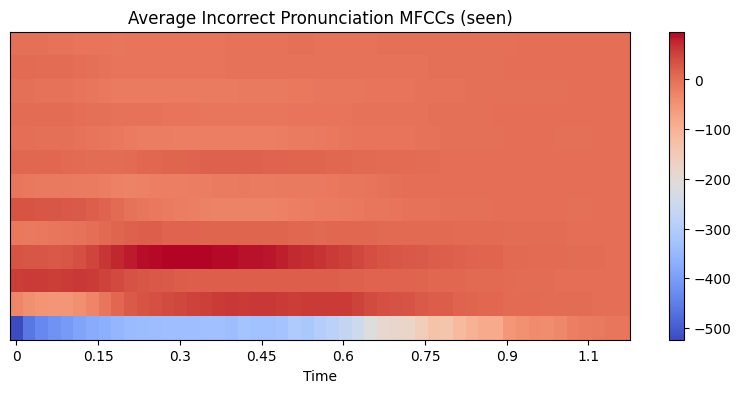

In [6]:
# Function to extract features from an audio file
def extract_features(file_path):
    y, sr = librosa.load(file_path)
    
    # MFCC (Mel-Frequency Cepstral Coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    # Spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    
    return mfccs, spectrogram

# Function to pad feature arrays to the same length
def pad_features(features, max_len):
    # If the feature array has fewer time steps than max_len, pad it with zeros
    if features.shape[1] < max_len:
        pad_width = max_len - features.shape[1]
        return np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
    # If it's longer, truncate it
    elif features.shape[1] > max_len:
        return features[:, :max_len]
    else:
        return features

# Function to process files and return averaged features
def process_folder(folder, letter_tag):
    all_mfccs = []
    all_spectrograms = []
    max_mfcc_len = 0
    max_spec_len = 0
    
    # Iterate through files in the folder
    for file in os.listdir(folder):
        # Process only files that contain the specified letter/tag in their name
        if letter_tag.lower() in file.lower():  # Case insensitive search
            file_path = os.path.join(folder, file)
            try:
                mfccs, spectrogram = extract_features(file_path)
                
                # Track the maximum length of MFCCs and spectrograms
                max_mfcc_len = max(max_mfcc_len, mfccs.shape[1])
                max_spec_len = max(max_spec_len, spectrogram.shape[1])
                
                # Append extracted features to the lists
                all_mfccs.append(mfccs)
                all_spectrograms.append(spectrogram)
            except (PermissionError, FileNotFoundError) as e:
                print(f"Skipping file {file_path} due to error: {e}")
    
    # Pad all feature arrays to the same length
    all_mfccs = [pad_features(mfcc, max_mfcc_len) for mfcc in all_mfccs]
    all_spectrograms = [pad_features(spec, max_spec_len) for spec in all_spectrograms]
    
    # Convert lists to arrays and compute the average MFCCs and spectrogram
    avg_mfccs = np.mean(all_mfccs, axis=0)
    avg_spectrogram = np.mean(all_spectrograms, axis=0)
    
    return avg_mfccs, avg_spectrogram

# Specify the letter/tag to filter the files (e.g., "seen" for the letter "س")
letter_tag = 'seen'  # Replace with your desired letter/tag

# Process both correct and incorrect folders for the specified letter/tag
incorrect_mfccs, incorrect_spectrograms = process_folder(incorrect_folder, letter_tag)
correct_mfccs, correct_spectrograms = process_folder(correct_folder, letter_tag)

# Plot the average spectrograms and MFCCs
if correct_mfccs is not None and incorrect_mfccs is not None:
    # Plot the average spectrograms for correct and incorrect samples
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(correct_spectrograms, ref=np.max), x_axis='time', y_axis='mel')
    plt.title(f'Average Correct Pronunciation Spectrogram ({letter_tag})')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(incorrect_spectrograms, ref=np.max), x_axis='time', y_axis='mel')
    plt.title(f'Average Incorrect Pronunciation Spectrogram ({letter_tag})')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

    # Plot the average MFCCs for correct and incorrect samples
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(correct_mfccs, x_axis='time')
    plt.title(f'Average Correct Pronunciation MFCCs ({letter_tag})')
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(incorrect_mfccs, x_axis='time')
    plt.title(f'Average Incorrect Pronunciation MFCCs ({letter_tag})')
    plt.colorbar()
    plt.show()
else:
    print(f"No valid data to plot for letter/tag: {letter_tag}")


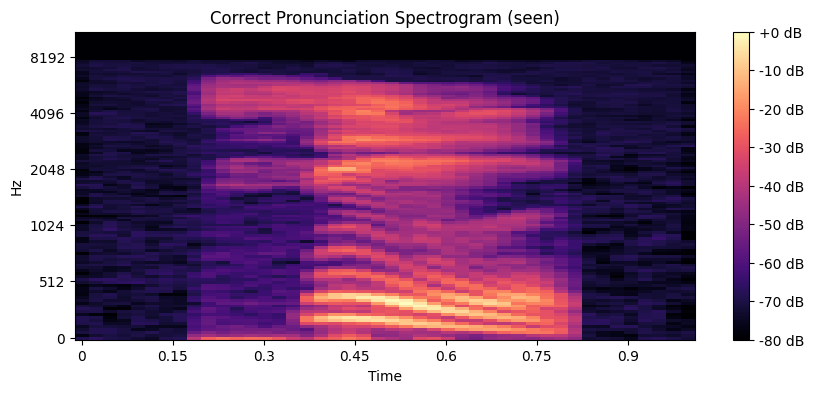

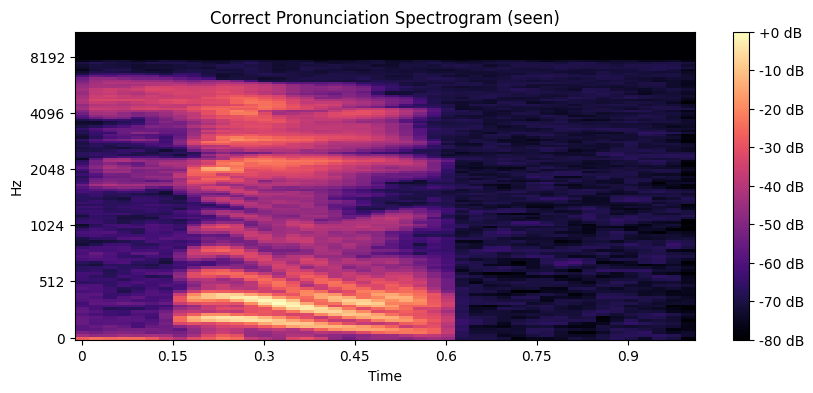

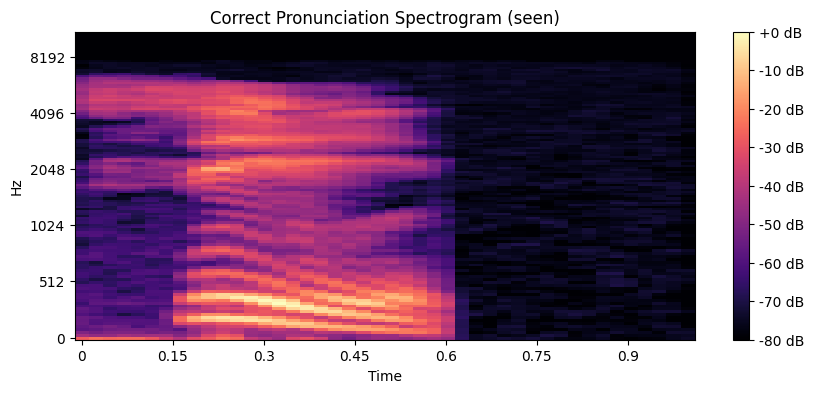

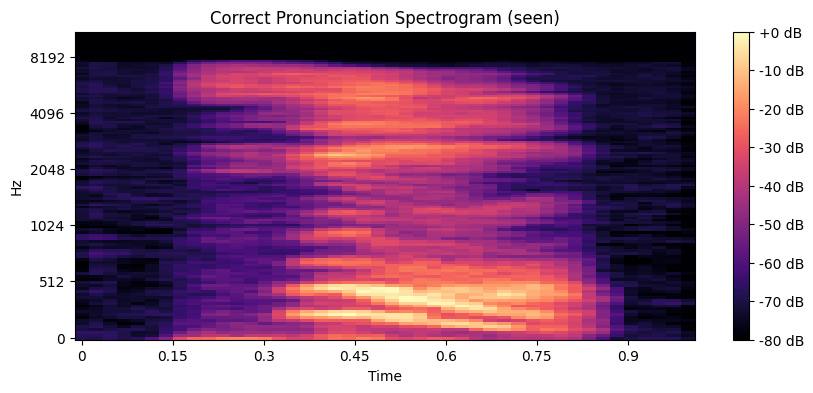

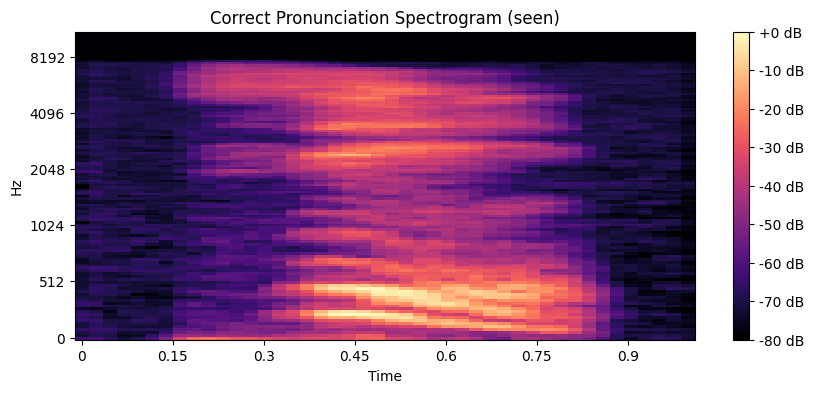

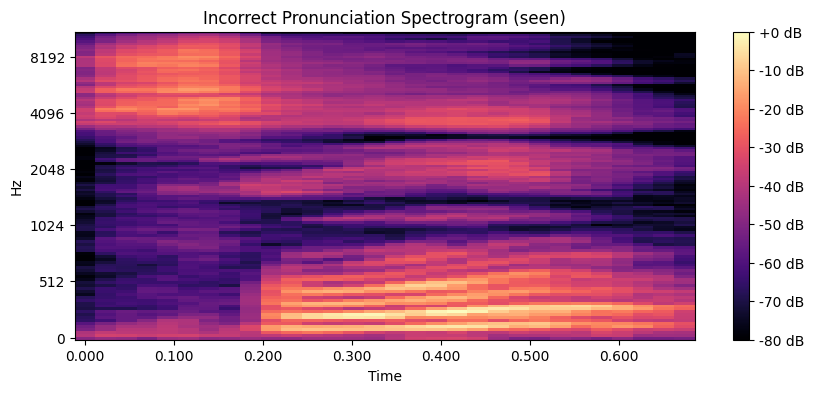

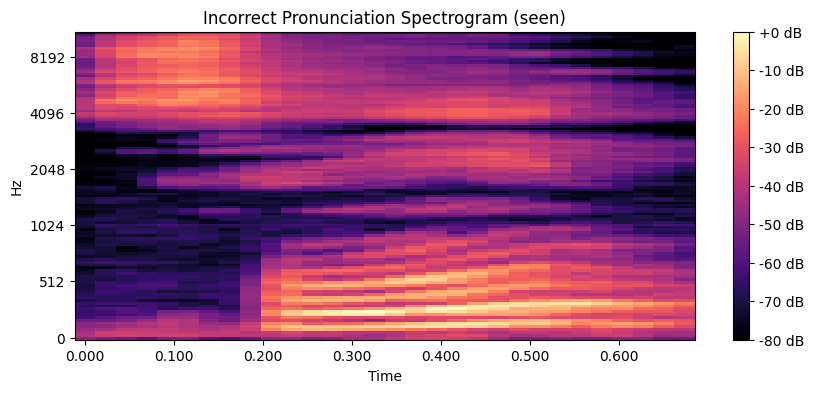

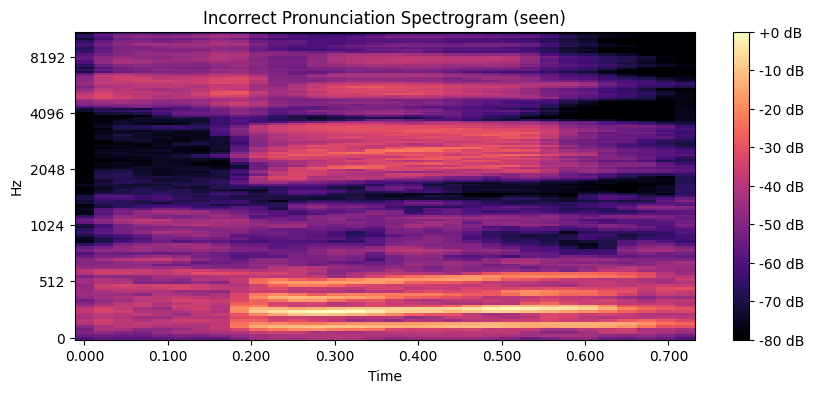

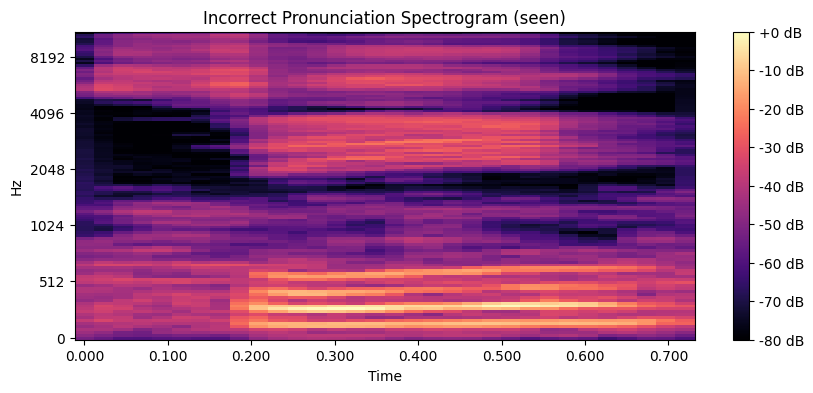

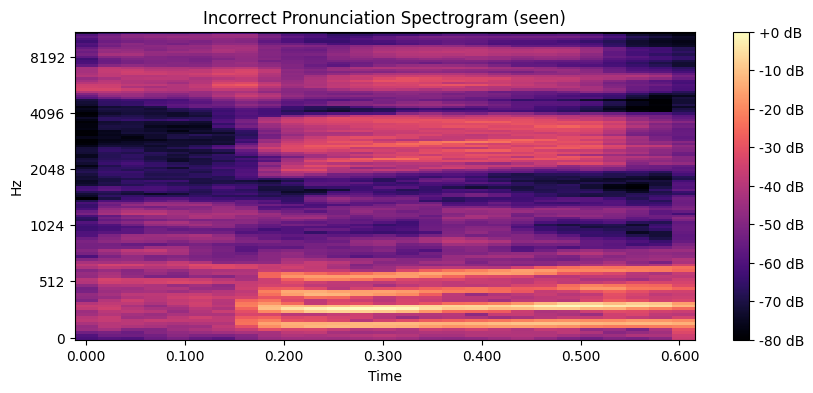

In [7]:
# Function to extract features from an audio file
def extract_spectogram(file_path):
    y, sr = librosa.load(file_path)
    
    # Spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    
    return spectrogram

# Function to pad feature arrays to the same length
def pad_features(features, max_len):
    # If the feature array has fewer time steps than max_len, pad it with zeros
    if features.shape[1] < max_len:
        pad_width = max_len - features.shape[1]
        return np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
    # If it's longer, truncate it
    elif features.shape[1] > max_len:
        return features[:, :max_len]
    else:
        return features

# Function to process files and return averaged features
def process_folder(folder, letter_tag, max_files=10000):
    all_spectrograms = []
    all_audio = []
    max_spec_len = 0
    
    file_count = 0
    # Iterate through files in the folder
    for file in os.listdir(folder):
        # Process only files that contain the specified letter/tag in their name
        if letter_tag.lower() in file.lower():  # Case insensitive search
            file_path = os.path.join(folder, file)
            try:
                spectrogram = extract_spectogram(file_path)
                
                # Track the maximum length spectrograms
                max_spec_len = max(max_spec_len, spectrogram.shape[1])
                
                # Append extracted features to the list
                all_spectrograms.append(spectrogram)
                all_audio.append(file_path)

                file_count += 1
                if file_count >= max_files:
                    break
            except (PermissionError, FileNotFoundError) as e:
                print(f"Skipping file {file_path} due to error: {e}")
    
    # Pad all feature arrays to the same length
    # all_spectrograms = [pad_features(spec, max_spec_len) for spec in all_spectrograms]
    
    
    return all_spectrograms, all_audio

# Specify the letter/tag to filter the files (e.g., "seen" for the letter "س")
letter_tag = 'seen'  # Replace with your desired letter/tag

# Process both correct and incorrect folders for the specified letter/tag
incorrect_spectrograms, incorrect_audio = process_folder(incorrect_folder, letter_tag,5)
correct_spectrograms, correct_audio = process_folder(correct_folder, letter_tag,5)

for i in range(correct_spectrograms.__len__()):
    # Plot the average spectrograms for correct and incorrect samples
    display(Audio(filename=correct_audio[i]))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(correct_spectrograms[i], ref=np.max), x_axis='time', y_axis='mel')
    plt.title(f'Correct Pronunciation Spectrogram ({letter_tag})')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

for i in range(incorrect_spectrograms.__len__()):
    # Plot the average spectrograms for correct and incorrect samples
    display(Audio(filename=incorrect_audio[i]))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(incorrect_spectrograms[i], ref=np.max), x_axis='time', y_axis='mel')
    plt.title(f'Incorrect Pronunciation Spectrogram ({letter_tag})')
    plt.colorbar(format='%+2.0f dB')
    plt.show()



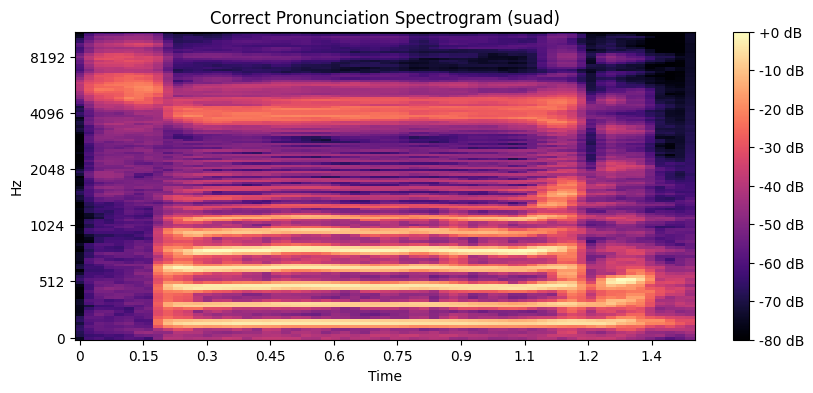

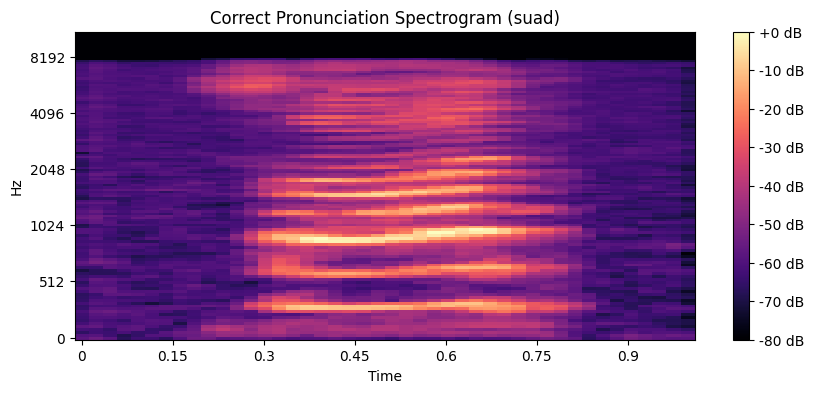

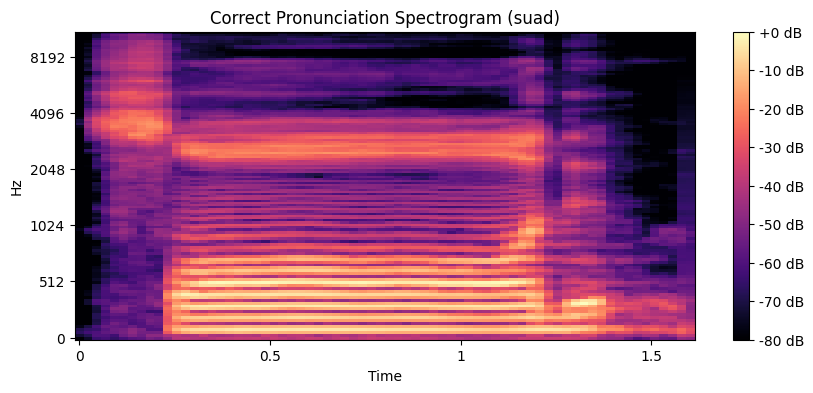

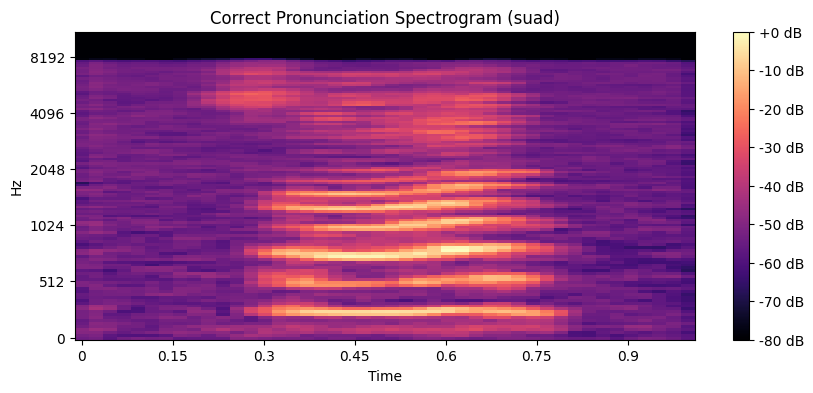

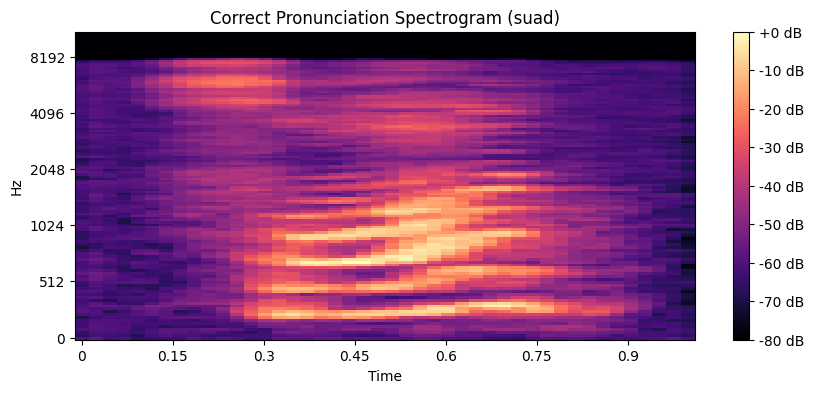

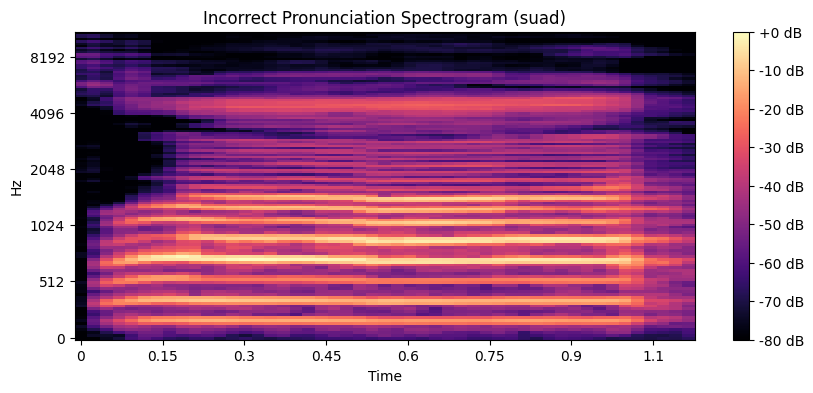

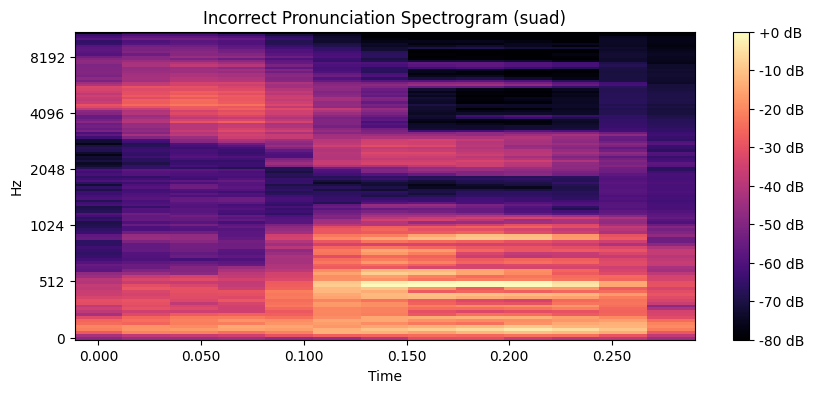

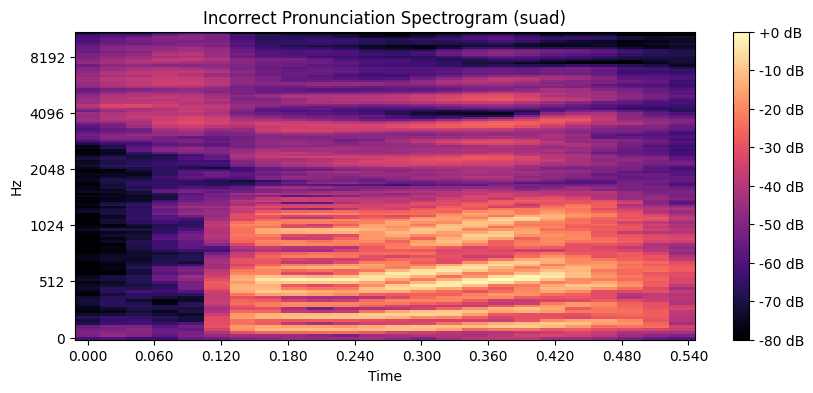

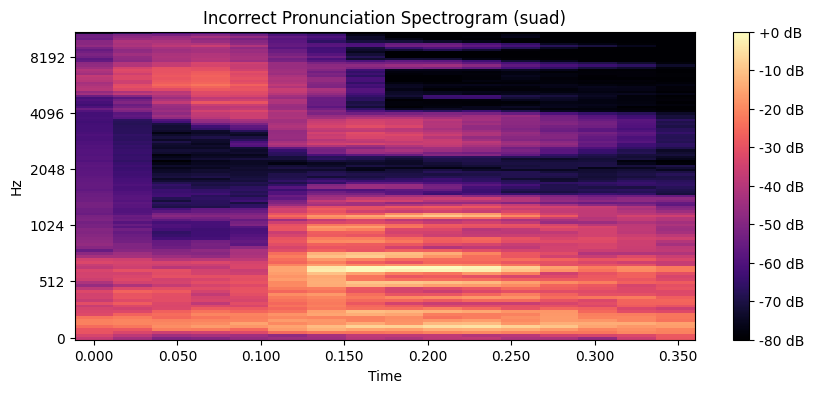

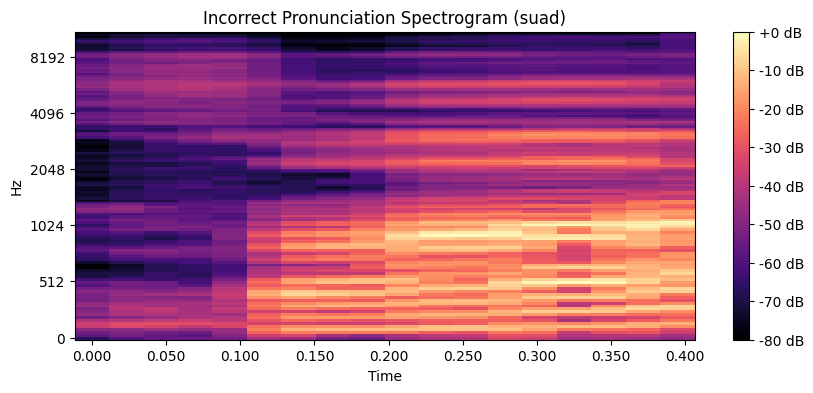

In [16]:
# Function to extract features from an audio file
def extract_spectogram(file_path):
    y, sr = librosa.load(file_path)
    
    # Spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    
    return spectrogram

# Function to pad feature arrays to the same length
def pad_features(features, max_len):
    # If the feature array has fewer time steps than max_len, pad it with zeros
    if features.shape[1] < max_len:
        pad_width = max_len - features.shape[1]
        return np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
    # If it's longer, truncate it
    elif features.shape[1] > max_len:
        return features[:, :max_len]
    else:
        return features

# Function to process files and return randomly selected features
def process_folder(folder, letter_tag, max_files=10000):
    all_spectrograms = []
    all_audio = []
    max_spec_len = 0
    
    # Get all files that contain the specified letter/tag
    filtered_files = [file for file in os.listdir(folder) if letter_tag.lower() in file.lower()]
    
    # Randomly sample up to max_files from the filtered files
    selected_files = random.sample(filtered_files, min(len(filtered_files), max_files))
    
    for file in selected_files:
        file_path = os.path.join(folder, file)
        try:
            spectrogram = extract_spectogram(file_path)
            
            # Track the maximum length spectrograms
            max_spec_len = max(max_spec_len, spectrogram.shape[1])
            
            # Append extracted features to the list
            all_spectrograms.append(spectrogram)
            all_audio.append(file_path)

        except (PermissionError, FileNotFoundError) as e:
            print(f"Skipping file {file_path} due to error: {e}")
    
    return all_spectrograms, all_audio

# Specify the letter/tag to filter the files (e.g., "seen" for the letter "س")
letter_tag = 'suad'  # Replace with your desired letter/tag

# Process both correct and incorrect folders for the specified letter/tag
incorrect_spectrograms, incorrect_audio = process_folder(incorrect_folder, letter_tag, 5)
correct_spectrograms, correct_audio = process_folder(correct_folder, letter_tag, 5)

for i in range(len(correct_spectrograms)):
    # Plot the average spectrograms for correct and incorrect samples
    display(Audio(filename=correct_audio[i]))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(correct_spectrograms[i], ref=np.max), x_axis='time', y_axis='mel')
    plt.title(f'Correct Pronunciation Spectrogram ({letter_tag})')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

for i in range(len(incorrect_spectrograms)):
    # Plot the average spectrograms for correct and incorrect samples
    display(Audio(filename=incorrect_audio[i]))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(incorrect_spectrograms[i], ref=np.max), x_axis='time', y_axis='mel')
    plt.title(f'Incorrect Pronunciation Spectrogram ({letter_tag})')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

In [12]:
min_length = min(correct_mfccs.size, incorrect_mfccs.size)
corr, _ = pearsonr(correct_mfccs.flatten()[:min_length], incorrect_mfccs.flatten()[:min_length])
print(f'Pearson correlation: {corr}')


Pearson correlation: 0.792959464767705


In [13]:
# Truncate the longer array to match the length of the shorter one
min_length = min(correct_mfccs.size, incorrect_mfccs.size)
correct_mfccs_truncated = correct_mfccs.flatten()[:min_length]
incorrect_mfccs_truncated = incorrect_mfccs.flatten()[:min_length]

mutual_info = mutual_info_regression(correct_mfccs_truncated.reshape(-1, 1), incorrect_mfccs_truncated)
print(f'Mutual Information: {mutual_info}')


Mutual Information: [1.1137466]


In [14]:
# Define the number of bins
num_bins = 10

# Bin the MFCC values into discrete intervals
correct_mfccs_binned = np.digitize(correct_mfccs_truncated, bins=np.linspace(np.min(correct_mfccs_truncated), np.max(correct_mfccs_truncated), num_bins))
incorrect_mfccs_binned = np.digitize(incorrect_mfccs_truncated, bins=np.linspace(np.min(incorrect_mfccs_truncated), np.max(incorrect_mfccs_truncated), num_bins))

# Create a contingency table
contingency_table = np.zeros((num_bins, num_bins))

for i in range(len(correct_mfccs_binned)):
    contingency_table[correct_mfccs_binned[i] - 1, incorrect_mfccs_binned[i] - 1] += 1

# Add a small constant to avoid zero elements
contingency_table += 1e-10

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-Square Statistic: {chi2}')
print(f'p-value: {p}')
print(f'Degrees of Freedom: {dof}')
print('Expected Frequencies:')
print(expected)

Chi-Square Statistic: 1382.4025784481491
p-value: 7.865589550676499e-236
Degrees of Freedom: 81
Expected Frequencies:
[[2.51177394e-02 5.02354788e-02 2.00941915e-01 7.53532182e-02
  5.02354788e-02 5.02354788e-02 1.25588697e-01 6.54317112e+00
  8.66562010e-01 1.25588697e-02]
 [2.82574568e-02 5.65149137e-02 2.26059655e-01 8.47723705e-02
  5.65149137e-02 5.65149137e-02 1.41287284e-01 7.36106750e+00
  9.74882261e-01 1.41287284e-02]
 [6.90737834e-02 1.38147567e-01 5.52590267e-01 2.07221350e-01
  1.38147567e-01 1.38147567e-01 3.45368917e-01 1.79937206e+01
  2.38304553e+00 3.45368917e-02]
 [1.56985871e-02 3.13971743e-02 1.25588697e-01 4.70957614e-02
  3.13971743e-02 3.13971743e-02 7.84929357e-02 4.08948195e+00
  5.41601256e-01 7.84929357e-03]
 [3.13971743e-12 6.27943485e-12 2.51177394e-11 9.41915228e-12
  6.27943485e-12 6.27943485e-12 1.56985871e-11 8.17896389e-10
  1.08320251e-10 1.56985871e-12]
 [3.13971743e-12 6.27943485e-12 2.51177394e-11 9.41915228e-12
  6.27943485e-12 6.27943485e-12 1.5